# **GOLD PRICE ANALYSIS PROJECT (1994-2023)**

## **Data Understanding**

### 1. Deskripsi Dataset

* **Nama File**: `gold_1994-2023.xlsx`
* **Jumlah Baris**: 30
* **Jumlah Kolom**: 15
* **Periode Data**: 1994 – 2023
* **Topik Data**: Faktor makroekonomi dan komoditas yang berkaitan dengan **harga emas**.

---

### 2. Struktur Dataset

| Kolom        | Tipe Data | Keterangan                                     |
| ------------ | --------- | ---------------------------------------------- |
| `year`       | int64     | Tahun pengamatan (1994–2023)                   |
| `gold_price` | object    | Harga emas (perlu dibersihkan menjadi numerik) |
| `fed_rate`   | float64   | Suku bunga The Fed (%)                         |
| `inflation`  | float64   | Tingkat inflasi (%)                            |
| `ec_growth`  | float64   | Pertumbuhan ekonomi (%)                        |
| `exch_rate`  | float64   | Nilai tukar Rupiah per USD                     |
| `real_int`   | float64   | Suku bunga riil (%)                            |
| `gdp_def`    | float64   | Deflator PDB (%)                               |
| `cpo`        | float64   | Harga Crude Palm Oil (CPO)                     |
| `tin`        | float64   | Harga timah (Tin)                              |
| `lend_int`   | float64   | Suku bunga pinjaman (%)                        |
| `Aluminium`  | float64   | Harga aluminium                                |
| `Nickel`     | float64   | Harga nikel                                    |
| `Platinum`   | float64   | Harga platinum                                 |
| `Perak`      | float64   | Harga perak (silver)                           |

---

### 3. Kualitas Data

* **Missing Values**: Tidak ada missing values di semua kolom.
* **Inconsistent Data**:

  * `gold_price` masih dalam format **object**, kemungkinan mengandung tanda pemisah ribuan/koma → perlu dikonversi ke numerik.

---

### 4. Statistik Deskriptif

#### a. Variabel Utama (contoh ringkasan)

* **Tahun (`year`)**: 1994 – 2023
* **Harga Emas (`gold_price`)**: 30 nilai unik (setiap tahun berbeda, perlu dibersihkan)
* **Fed Rate (`fed_rate`)**: Rata-rata 2.47%, min 0.08%, max 6.24%
* **Inflasi (`inflation`)**: Rata-rata 8.48%, min 1.56%, max 58.45%
* **Pertumbuhan Ekonomi (`ec_growth`)**: Rata-rata 4.44%, min -13.12%, max 8.22%

#### b. Variabel Komoditas (contoh ringkasan)

* **CPO**: Rata-rata 54.9
* **Timah (`tin`)**: Rata-rata 14,534
* **Aluminium**: Rata-rata 1,884
* **Nikel**: Rata-rata 14,304
* **Platinum**: Rata-rata 934
* **Perak (Silver)**: Rata-rata 14.8

---

### 5. Insight Awal

* Dataset berfokus pada **hubungan harga emas** dengan faktor makroekonomi dan harga komoditas lain.
* Potensi analisis:

  * Korelasi harga emas dengan inflasi, suku bunga, nilai tukar.
  * Hubungan harga emas dengan komoditas lain (CPO, timah, aluminium, nikel, platinum, perak).

---

## **Download Data**

In [1]:
import os
import gdown

# Buat folder data jika belum ada
os.makedirs("data", exist_ok=True)

# Link Google Drive (ubah ke format file-id)
url = "https://drive.google.com/uc?id=12DTi1juIAjzv7QL1oFzsMaubsa9kJQhO"
output = "data/gold_1994-2023.xlsx"

# Download hanya jika file belum ada
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)
    print(f"File berhasil diunduh dan disimpan di {output}")
else:
    print(f"File sudah ada di {output}, skip download.")

File sudah ada di data/gold_1994-2023.xlsx, skip download.


## **Import Libraries**

In [ ]:
# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Tests
from scipy import stats
from scipy.stats import normaltest, shapiro, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Time Series
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

from arch import arch_model

# Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Deep Learning
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
    from tensorflow.keras.callbacks import EarlyStopping
    KERAS_AVAILABLE = True
except:
    KERAS_AVAILABLE = False
    print("TensorFlow/Keras not available. LSTM, ANN, and CNN-LSTM models will be skipped.")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Warning Handling
import warnings
warnings.filterwarnings('ignore')

d:\Projects\Bu Lina\Gold Price Prediction\.venv\lib\site-packages\property_cached\__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## **Seeding**

In [ ]:
# ============================================================================
# GLOBAL SEEDING
# ============================================================================
import os
import random
import numpy as np

SEED = 42  # bisa ganti angka seed sesuai kebutuhan

# Python & OS
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# XGBoost
import xgboost as xgb
xgb_rng = np.random.RandomState(SEED)

# TensorFlow / Keras (jika tersedia)
try:
    import tensorflow as tf
    tf.random.set_seed(SEED)
except:
    pass

print(f"Global seeding berhasil dengan SEED={SEED}")


Global seeding berhasil dengan SEED=42


## **Eksploratory Data Analysis (EDA)**

In [20]:
# Load data
df = pd.read_excel('data/gold_1994-2023.xlsx')

In [21]:
print("\n0.1.1 DESKRIPSI DATASET")
print("-"*80)
print(f"Nama File: gold_1994-2023.xlsx")
print(f"Jumlah Baris: {df.shape[0]}")
print(f"Jumlah Kolom: {df.shape[1]}")
print(f"Periode Data: {df['year'].min()} - {df['year'].max()}")


0.1.1 DESKRIPSI DATASET
--------------------------------------------------------------------------------
Nama File: gold_1994-2023.xlsx
Jumlah Baris: 30
Jumlah Kolom: 16
Periode Data: 1994 - 2023


In [22]:
print("\n0.1.2 STRUKTUR DATASET")
print("-"*80)
print(df.info())
print("\nFirst 5 rows:")
print(df.head())


0.1.2 STRUKTUR DATASET
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         30 non-null     int64  
 1   gold_price   30 non-null     float64
 2   fed_rate     30 non-null     float64
 3   inflation    30 non-null     float64
 4   ec_growth    30 non-null     float64
 5   exch_rate    30 non-null     float64
 6   real_int     30 non-null     float64
 7   gdp_def      30 non-null     float64
 8   cpo          30 non-null     float64
 9   tin          30 non-null     float64
 10  lend_int     30 non-null     float64
 11  Aluminium    30 non-null     float64
 12  Nickel       30 non-null     float64
 13  Platinum     30 non-null     float64
 14  Perak        30 non-null     float64
 15  Unnamed: 15  1 non-null      object 
dtypes: float64(14), int64(1), objec

In [25]:
# Remove unnamed columns if any
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Clean gold_price column (remove comma/thousands separator)
if df['gold_price'].dtype == 'object':
    df['gold_price'] = df['gold_price'].str.replace(',', '').str.replace('.', '').astype(float)

In [26]:
print("\n0.1.3 KUALITAS DATA")
print("-"*80)
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal Missing Values: {df.isnull().sum().sum()}")



0.1.3 KUALITAS DATA
--------------------------------------------------------------------------------
Missing Values:
year          0
gold_price    0
fed_rate      0
inflation     0
ec_growth     0
exch_rate     0
real_int      0
gdp_def       0
cpo           0
tin           0
lend_int      0
Aluminium     0
Nickel        0
Platinum      0
Perak         0
dtype: int64

Total Missing Values: 0


In [27]:
print("\n0.1.4 STATISTIK DESKRIPTIF")
print("-"*80)
print(df.describe())


0.1.4 STATISTIK DESKRIPTIF
--------------------------------------------------------------------------------
              year   gold_price  fed_rate  inflation  ec_growth     exch_rate  \
count    30.000000    30.000000  30.00000  30.000000  30.000000     30.000000   
mean   2008.500000   935.523338   2.46600   8.481230   4.438370   9938.259521   
std       8.803408   573.425888   2.21228  10.233847   3.821554   3754.664354   
min    1994.000000   270.989167   0.08000   1.560130 -13.126725   2160.753675   
25%    2001.250000   384.048542   0.22750   3.908965   4.720001   8812.537500   
50%    2008.500000   922.336583   1.76000   6.294631   5.040587   9701.852083   
75%    2015.750000  1361.680417   4.97000   9.198244   5.933421  13362.707110   
max    2023.000000  1942.665833   6.24000  58.451044   8.220007  15236.884662   

        real_int    gdp_def         cpo           tin   lend_int    Aluminium  \
count  30.000000  30.000000   30.000000     30.000000  30.000000    30.000000   

In [28]:
# Correlation with gold_price
print("\nKorelasi dengan Harga Emas:")
correlations = df.corr()['gold_price'].sort_values(ascending=False)
print(correlations)

print("\n0.1.5 INSIGHT AWAL")
print("-"*80)
print("✓ Dataset fokus pada hubungan harga emas dengan faktor makroekonomi")
print("✓ Periode analisis: 30 tahun (1994-2023)")
print("✓ Variabel ekonomi: Fed rate, inflasi, pertumbuhan ekonomi, nilai tukar")
print("✓ Variabel komoditas: CPO, timah, aluminium, nikel, platinum, perak")


Korelasi dengan Harga Emas:
gold_price    1.000000
tin           0.942993
year          0.922562
Perak         0.885612
cpo           0.753968
exch_rate     0.710543
Platinum      0.641273
Aluminium     0.561791
Nickel        0.507015
real_int      0.113259
ec_growth     0.091401
gdp_def      -0.423295
inflation    -0.442662
fed_rate     -0.619093
lend_int     -0.795449
Name: gold_price, dtype: float64

0.1.5 INSIGHT AWAL
--------------------------------------------------------------------------------
✓ Dataset fokus pada hubungan harga emas dengan faktor makroekonomi
✓ Periode analisis: 30 tahun (1994-2023)
✓ Variabel ekonomi: Fed rate, inflasi, pertumbuhan ekonomi, nilai tukar
✓ Variabel komoditas: CPO, timah, aluminium, nikel, platinum, perak


## **Trend Visualization**

### Gold Price Trend

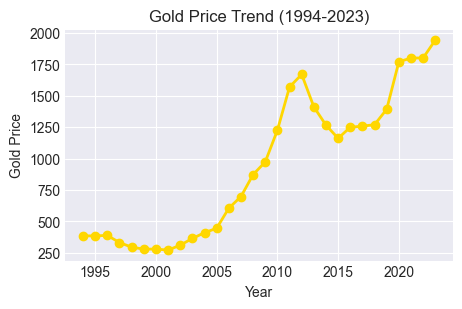

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(df['year'], df['gold_price'], marker='o', linewidth=2, color='gold')
plt.title('Gold Price Trend (1994-2023)')
plt.xlabel('Year')
plt.ylabel('Gold Price')
plt.grid(True)
plt.show()

### Fed Rate Trend

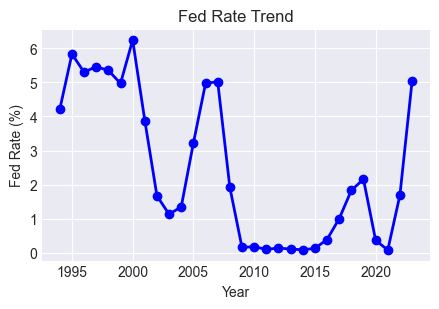

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(df['year'], df['fed_rate'], marker='o', linewidth=2, color='blue')
plt.title('Fed Rate Trend')
plt.xlabel('Year')
plt.ylabel('Fed Rate (%)')
plt.grid(True)
plt.show()

### Inflation Trend

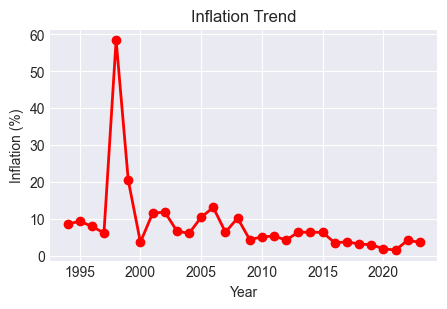

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(df['year'], df['inflation'], marker='o', linewidth=2, color='red')
plt.title('Inflation Trend')
plt.xlabel('Year')
plt.ylabel('Inflation (%)')
plt.grid(True)
plt.show()

### Exchange Rate Trend

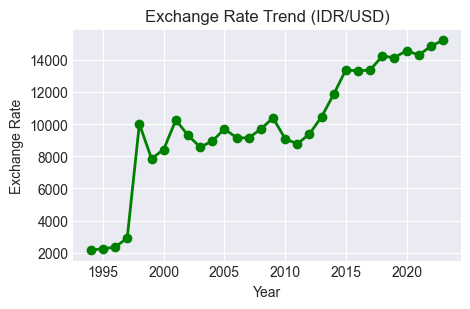

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(df['year'], df['exch_rate'], marker='o', linewidth=2, color='green')
plt.title('Exchange Rate Trend (IDR/USD)')
plt.xlabel('Year')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

### Correlation Heatmap

In [38]:
df.columns

Index(['year', 'gold_price', 'fed_rate', 'inflation', 'ec_growth', 'exch_rate',
       'real_int', 'gdp_def', 'cpo', 'tin', 'lend_int', 'Aluminium', 'Nickel',
       'Platinum', 'Perak'],
      dtype='object')

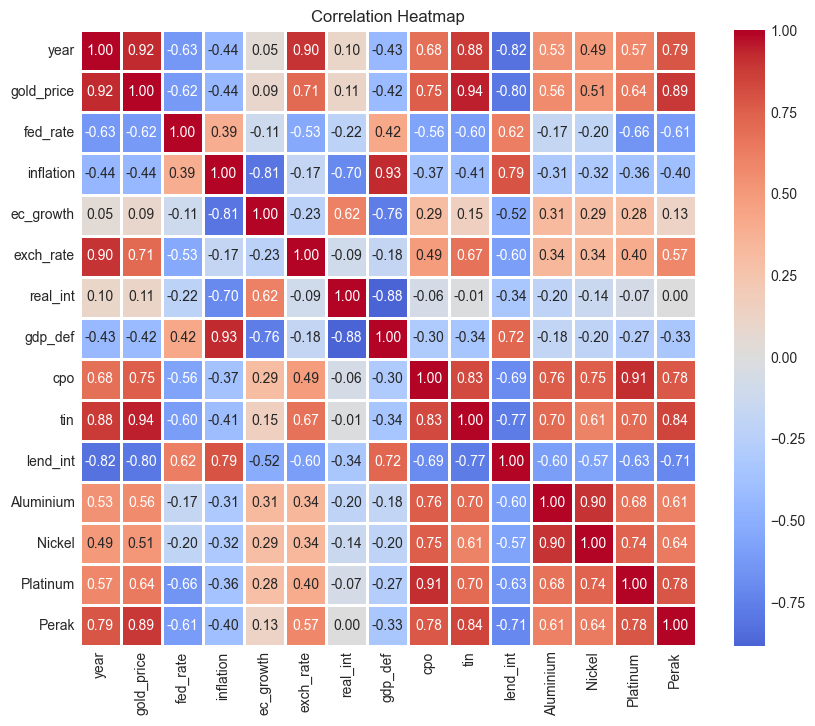

In [39]:
corr_matrix = df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1)
plt.title('Correlation Heatmap')
plt.show()

### Distribution of Gold Price

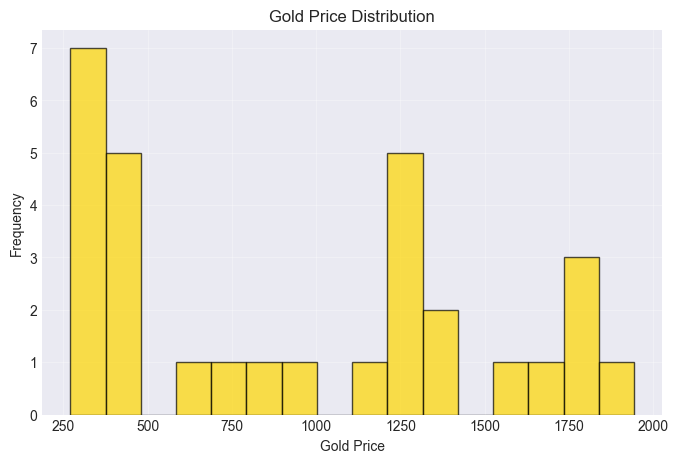

In [44]:
plt.figure(figsize=(8,5))
plt.hist(df['gold_price'], bins=16, color='gold', edgecolor='black', alpha=0.7)
plt.title('Gold Price Distribution')
plt.xlabel('Gold Price')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


## **Data Testing**

### Classic Test (Stationarity)

In [64]:
X = df.drop(['year', 'gold_price'], axis=1)
y = df['gold_price']

# --- 1. Log Transformation (optional)
y_log = np.log(y)

# --- 2. First Differencing
y_diff = y.diff().dropna()

# --- 3. Log + Differencing
y_logdiff = y_log.diff().dropna()

In [54]:
def stationarity_tests(series, name="Series"):
    print(f"\n>>> Uji Stasioneritas untuk {name}")
    print("-"*80)

    # KPSS Test
    kpss_result = kpss(series, regression='c', nlags="auto")
    print(f"\nKPSS Test:")
    print(f"  KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"  p-value: {kpss_result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"    {key}: {value:.4f}")
    if kpss_result[1] > 0.05:
        print("  → Data STASIONER (p > 0.05)")
    else:
        print("  → Data TIDAK STASIONER (p <= 0.05)")

#### Pengujian

In [55]:
stationarity_tests(y, "Original Data (Gold Price)")


>>> Uji Stasioneritas untuk Original Data (Gold Price)
--------------------------------------------------------------------------------

KPSS Test:
  KPSS Statistic: 0.7722
  p-value: 0.0100
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  → Data TIDAK STASIONER (p <= 0.05)


In [56]:
stationarity_tests(y_log.dropna(), "Log Transform")


>>> Uji Stasioneritas untuk Log Transform
--------------------------------------------------------------------------------

KPSS Test:
  KPSS Statistic: 0.7545
  p-value: 0.0100
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  → Data TIDAK STASIONER (p <= 0.05)


In [57]:
stationarity_tests(y_diff, "First Difference")


>>> Uji Stasioneritas untuk First Difference
--------------------------------------------------------------------------------

KPSS Test:
  KPSS Statistic: 0.1394
  p-value: 0.1000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  → Data STASIONER (p > 0.05)


In [58]:
stationarity_tests(y_logdiff, "Log + First Difference")


>>> Uji Stasioneritas untuk Log + First Difference
--------------------------------------------------------------------------------

KPSS Test:
  KPSS Statistic: 0.1292
  p-value: 0.1000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  → Data STASIONER (p > 0.05)


### Heterokedastatis Test

In [61]:
print("\n0.2.2 HETEROSKEDASTICITY TEST")
print("-"*80)

# Simple linear regression for residuals
from sklearn.linear_model import LinearRegression
from statsmodels.tools import add_constant

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
residuals = y - y_pred

# Add constant to X for Breusch-Pagan test (required by statsmodels)
X_with_const = add_constant(X)

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_with_const)
print("Breusch-Pagan Test:")
print(f"  LM Statistic: {bp_test[0]:.4f}")
print(f"  p-value: {bp_test[1]:.4f}")
print(f"  F-statistic: {bp_test[2]:.4f}")
print(f"  F p-value: {bp_test[3]:.4f}")
if bp_test[1] < 0.05:
    print("  → HETEROSKEDASTISITAS TERDETEKSI (p < 0.05)")
else:
    print("  → HOMOSKEDASTISITAS (p >= 0.05)")


0.2.2 HETEROSKEDASTICITY TEST
--------------------------------------------------------------------------------
Breusch-Pagan Test:
  LM Statistic: 12.2686
  p-value: 0.5057
  F-statistic: 0.8516
  F p-value: 0.6101
  → HOMOSKEDASTISITAS (p >= 0.05)


### Autocorrelation Test 

In [62]:
print("\n0.2.3 AUTOCORRELATION TEST")
print("-"*80)

# Durbin-Watson test
dw_stat = durbin_watson(residuals)
print("Durbin-Watson Test:")
print(f"  DW Statistic: {dw_stat:.4f}")
if dw_stat < 1.5:
    print("  → AUTOKORELASI POSITIF")
elif dw_stat > 2.5:
    print("  → AUTOKORELASI NEGATIF")
else:
    print("  → TIDAK ADA AUTOKORELASI")

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
print(f"\nLjung-Box Test (lag 1):")
print(f"  Statistic: {lb_test['lb_stat'].iloc[0]:.4f}")
print(f"  p-value: {lb_test['lb_pvalue'].iloc[0]:.4f}")
if lb_test['lb_pvalue'].iloc[0] < 0.05:
    print("  → AUTOKORELASI TERDETEKSI")
else:
    print("  → TIDAK ADA AUTOKORELASI")


0.2.3 AUTOCORRELATION TEST
--------------------------------------------------------------------------------
Durbin-Watson Test:
  DW Statistic: 2.2447
  → TIDAK ADA AUTOKORELASI

Ljung-Box Test (lag 1):
  Statistic: 0.5628
  p-value: 0.4531
  → TIDAK ADA AUTOKORELASI


### Multi Correlation Test

In [63]:
X.columns

Index(['fed_rate', 'inflation', 'ec_growth', 'exch_rate', 'real_int',
       'gdp_def', 'cpo', 'tin', 'lend_int', 'Aluminium', 'Nickel', 'Platinum',
       'Perak'],
      dtype='object')

In [12]:
print("\n0.2.4 MULTICOLLINEARITY TEST")
print("-"*80)

# VIF calculation
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)
print("Variance Inflation Factor (VIF):")
print(vif_data)
print("\nInterpretasi:")
print("  VIF < 5: Tidak ada multikolinearitas")
print("  VIF 5-10: Multikolinearitas sedang")
print("  VIF > 10: Multikolinearitas tinggi")


0.2.4 MULTICOLLINEARITY TEST
--------------------------------------------------------------------------------
Variance Inflation Factor (VIF):
     Variable         VIF
5     gdp_def  408.439213
8    lend_int  376.572611
9   Aluminium  190.341468
4    real_int  141.726385
11   Platinum  121.662181
6         cpo   72.126704
7         tin   52.394930
10     Nickel   37.479860
1   inflation   34.101870
12      Perak   24.300016
3   exch_rate   19.170536
2   ec_growth   18.629027
0    fed_rate   14.229006

Interpretasi:
  VIF < 5: Tidak ada multikolinearitas
  VIF 5-10: Multikolinearitas sedang
  VIF > 10: Multikolinearitas tinggi


### Normality Test


0.2.5 NORMALITY TEST
--------------------------------------------------------------------------------
Jarque-Bera Test:
  Statistic: 4.1588
  p-value: 0.1250
  → Data BERDISTRIBUSI NORMAL (p >= 0.05)

Shapiro-Wilk Test:
  Statistic: 0.9595
  p-value: 0.3001
  → Data BERDISTRIBUSI NORMAL (p >= 0.05)


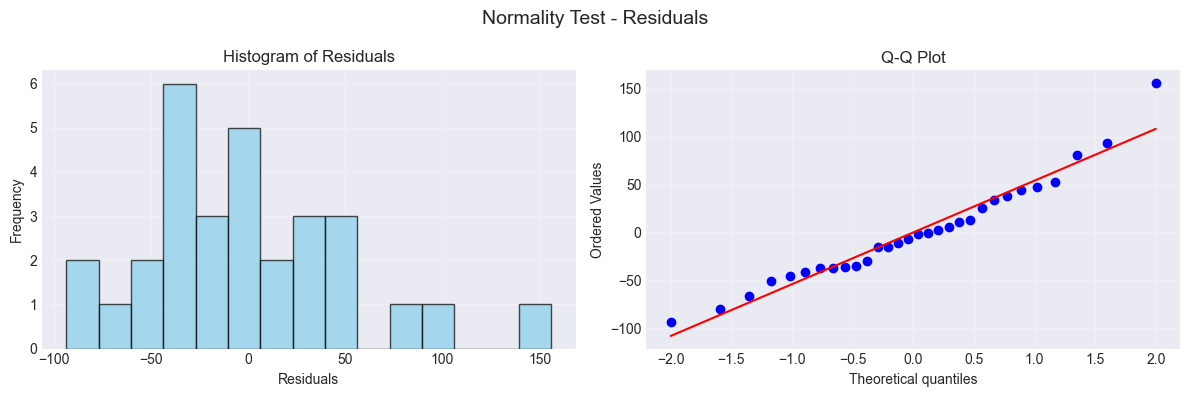

In [14]:
print("\n0.2.5 NORMALITY TEST")
print("-"*80)

# Jarque-Bera test
jb_stat, jb_pvalue = jarque_bera(residuals)
print("Jarque-Bera Test:")
print(f"  Statistic: {jb_stat:.4f}")
print(f"  p-value: {jb_pvalue:.4f}")
if jb_pvalue < 0.05:
    print("  → Data TIDAK BERDISTRIBUSI NORMAL (p < 0.05)")
else:
    print("  → Data BERDISTRIBUSI NORMAL (p >= 0.05)")

# Shapiro-Wilk test
shapiro_stat, shapiro_pvalue = shapiro(residuals)
print(f"\nShapiro-Wilk Test:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  p-value: {shapiro_pvalue:.4f}")
if shapiro_pvalue < 0.05:
    print("  → Data TIDAK BERDISTRIBUSI NORMAL (p < 0.05)")
else:
    print("  → Data BERDISTRIBUSI NORMAL (p >= 0.05)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Normality Test - Residuals', fontsize=14)

# Histogram
axes[0].hist(residuals, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Histogram of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Econometric Test

In [89]:
variabels = df.columns.tolist()
variabels.remove('year')

In [90]:
variabels

['gold_price',
 'fed_rate',
 'inflation',
 'ec_growth',
 'exch_rate',
 'real_int',
 'gdp_def',
 'cpo',
 'tin',
 'lend_int',
 'Aluminium',
 'Nickel',
 'Platinum',
 'Perak',
 'gold_price_logdiff']

In [100]:
print("\n0.2.6 ECONOMETRIC TEST")
print("-"*80)

# Granger Causality Test (example: fed_rate -> gold_price)
print("Granger Causality Test (Fed Rate → Gold Price):")
data_granger = df[['gold_price', 'fed_rate']].dropna()
try:
    gc_result = grangercausalitytests(data_granger, maxlag=3, verbose=False)
    for lag in range(1, 4):
        p_value = gc_result[lag][0]['ssr_ftest'][1]
        print(f"  Lag {lag}: p-value = {p_value:.4f}")
        if p_value < 0.05:
            print(f"    → Fed Rate Granger-cause Gold Price (p < 0.05)")
        else:
            print(f"    → No Granger causality (p >= 0.05)")
except:
    print("  Unable to perform Granger test (insufficient data or singularity)")

# Cointegration Test (Johansen)
print("\nJohansen Cointegration Test:")
selected_vars = df[['gold_price', 'fed_rate', 'inflation', 'exch_rate']].dropna()
try:
    johansen_result = coint_johansen(selected_vars, det_order=0, k_ar_diff=1)
    print(f"  Trace Statistic:")
    for i in range(len(johansen_result.lr1)):
        print(f"    r <= {i}: {johansen_result.lr1[i]:.4f} (Critical 5%: {johansen_result.cvt[i, 1]:.4f})")
except:
    print("  Unable to perform Johansen test")


0.2.6 ECONOMETRIC TEST
--------------------------------------------------------------------------------
Granger Causality Test (Fed Rate → Gold Price):
  Lag 1: p-value = 0.8623
    → No Granger causality (p >= 0.05)
  Lag 2: p-value = 0.6985
    → No Granger causality (p >= 0.05)
  Lag 3: p-value = 0.6302
    → No Granger causality (p >= 0.05)

Johansen Cointegration Test:
  Trace Statistic:
    r <= 0: 60.3616 (Critical 5%: 47.8545)
    r <= 1: 20.6135 (Critical 5%: 29.7961)
    r <= 2: 8.3645 (Critical 5%: 15.4943)
    r <= 3: 0.2093 (Critical 5%: 3.8415)


## **Kesimpulan Hasil Pengujian Data**

1. **Uji Stasioneritas (ADF & KPSS)**

   * Hasil **ADF Test** menunjukkan p-value = 0.9820 (≥ 0.05) → **tidak stasioner**.
   * Hasil **KPSS Test** menunjukkan p-value = 0.0100 (≤ 0.05) → **tidak stasioner**.
    
    **Kesimpulan:** Data belum stasioner, perlu dilakukan transformasi/differencing sebelum masuk ke model deret waktu.

2. **Uji Heteroskedastisitas (Breusch-Pagan)**

   * p-value LM = 0.5057 dan F = 0.6101 (≥ 0.05) → **tidak ada heteroskedastisitas**.
    
    **Kesimpulan:** Varian residual konstan (homoskedastis).

3. **Uji Autokorelasi (Durbin-Watson & Ljung-Box)**

   * **Durbin-Watson** = 2.2447 (mendekati 2) → tidak ada autokorelasi.
   * **Ljung-Box** p-value = 0.4531 (≥ 0.05) → tidak ada autokorelasi.
    
     **Kesimpulan:** Residual bebas dari autokorelasi.

4. **Uji Multikolinearitas (VIF)**

   * Banyak variabel memiliki **VIF jauh > 10**, misalnya `gdp_def` (408), `lend_int` (376), `Aluminium` (190), dll.
    
    **Kesimpulan:** Terjadi **multikolinearitas sangat tinggi**, sehingga perlu reduksi variabel (misalnya PCA, regularisasi, atau eliminasi variabel).

5. **Uji Normalitas (Jarque-Bera & Shapiro-Wilk)**

   * p-value JB = 0.1250 dan SW = 0.3001 (≥ 0.05).
    
    **Kesimpulan:** Data residual **berdistribusi normal**.

6. **Uji Ekonometrik**

   * **Granger Causality (Fed Rate → Gold Price):** semua lag (1–3) p-value ≥ 0.05 → **tidak ada hubungan sebab akibat jangka pendek**.
   * **Johansen Cointegration Test:**

     * r ≤ 0: 60.3616 > 47.8545 → terdapat minimal **1 vektor kointegrasi**.
     * r ≤ 1, r ≤ 2, r ≤ 3 tidak signifikan → hanya ada **1 hubungan kointegrasi jangka panjang**.
     
      **Kesimpulan:** Tidak ada hubungan kausal jangka pendek, tetapi ada **kointegrasi jangka panjang** antar variabel.

---

## **Ringkasan Akhir**

* Data **tidak stasioner** → perlu differencing/transformasi.
* Data **homoskedastis** dan **tidak ada autokorelasi**, sehingga residual sudah memenuhi asumsi klasik.
* **Multikolinearitas sangat tinggi** → model regresi linear biasa kurang tepat; perlu penanganan khusus.
* Residual **normal** → asumsi distribusi terpenuhi.
* Secara ekonometrik, **tidak ada hubungan kausal jangka pendek** (Granger), tetapi terdapat **hubungan jangka panjang (kointegrasi)** antar variabel.


## **Data Preprocessing**

In [4]:
# =====================================================================
# PIPELINE - 3 SKEMA PREPROCESSING (PCA, FEATURE IMPORTANCE, NO REDUCTION)
# =====================================================================

import warnings, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# PyCaret
from pycaret.regression import setup, compare_models, create_model, tune_model, finalize_model, predict_model

ModuleNotFoundError: No module named 'pycaret'

In [3]:
# ---------------------------------------------------------------------
# 1) Load Data
# ---------------------------------------------------------------------
DATA_PATH = "data/gold_1994-2023.xlsx"
df = pd.read_excel(DATA_PATH)

# Bersihkan
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
if df['gold_price'].dtype == 'object':
    df['gold_price'] = df['gold_price'].astype(str).str.replace(',', '').str.replace('.', '').astype(float)

TARGET = 'gold_price'
FEATURES = [c for c in df.columns if c not in ['year', TARGET]]

X = df[FEATURES].fillna(df[FEATURES].median())
y = df[TARGET]

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

NameError: name 'RobustScaler' is not defined

In [ ]:




# ---------------------------------------------------------------------
# 2) Preprocessing functions
# ---------------------------------------------------------------------
def apply_pca(X, variance=0.95):
    pca = PCA(n_components=variance, random_state=42)
    X_p = pca.fit_transform(X)
    cols = [f"PC{i+1}" for i in range(X_p.shape[1])]
    return pd.DataFrame(X_p, columns=cols, index=X.index)

def select_from_rf(X, y, threshold="median"):
    rf = RandomForestRegressor(n_estimators=300, random_state=42)
    rf.fit(X, y)
    sel = SelectFromModel(rf, threshold=threshold, prefit=True)
    X_sel = sel.transform(X)
    selected_cols = list(X.columns[sel.get_support()])
    return pd.DataFrame(X_sel, columns=selected_cols, index=X.index)

# ---------------------------------------------------------------------
# 3) Deep Learning Models
# ---------------------------------------------------------------------
def run_ann(X_train, X_test, y_train, y_test):
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train.shape[1]),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=8, callbacks=[es], verbose=0)
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    return mae

def create_sequences(X, y, timesteps=3):
    Xs, ys = [], []
    for i in range(len(X) - timesteps):
        Xs.append(X[i:(i+timesteps), :])
        ys.append(y[i+timesteps])
    return np.array(Xs), np.array(ys)

def run_lstm(X, y):
    timesteps = 3
    X_seq, y_seq = create_sequences(X, y, timesteps)
    if len(X_seq) == 0:
        return np.nan
    X_tr, X_te, y_tr, y_te = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    model = Sequential([
        LSTM(64, input_shape=(timesteps, X.shape[1])),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
    model.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=8, callbacks=[es], verbose=0)
    loss, mae = model.evaluate(X_te, y_te, verbose=0)
    return mae

def run_cnn(X, y):
    timesteps = 3
    X_seq, y_seq = create_sequences(X, y, timesteps)
    if len(X_seq) == 0:
        return np.nan
    X_tr, X_te, y_tr, y_te = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    model = Sequential([
        Conv1D(64, kernel_size=2, activation="relu", input_shape=(timesteps, X.shape[1])),
        MaxPooling1D(pool_size=1),
        Flatten(),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    es = EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True)
    model.fit(X_tr, y_tr, validation_split=0.2, epochs=200, batch_size=8, callbacks=[es], verbose=0)
    loss, mae = model.evaluate(X_te, y_te, verbose=0)
    return mae

# ---------------------------------------------------------------------
# 4) Pipeline untuk 3 Skema
# ---------------------------------------------------------------------
results = []

for skema, X_proc in [
    ("PCA", apply_pca(X_scaled, variance=0.95)),
    ("Feature Importance", select_from_rf(X_scaled, y, threshold="median")),
    ("No Reduction", X_scaled)
]:
    print(f"\n=== Skema: {skema} ===")

    # ---- PyCaret
    df_py = pd.concat([X_proc.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    s = setup(df_py, target=TARGET, session_id=42, silent=True, verbose=False, fold=5)
    best = compare_models(sort="RMSE", n_select=1)
    tuned = tune_model(best, optimize="RMSE")
    final = finalize_model(tuned)
    preds = predict_model(final, data=df_py)
    rmse = np.sqrt(((preds["gold_price"] - preds["Label"])**2).mean())
    mae = (preds["gold_price"] - preds["Label"]).abs().mean()
    r2 = 1 - ((preds["gold_price"] - preds["Label"])**2).sum() / ((preds["gold_price"] - preds["gold_price"].mean())**2).sum()

    # ---- Deep Learning
    X_tr, X_te, y_tr, y_te = train_test_split(X_proc.values, y.values, test_size=0.2, random_state=42)
    ann_mae = run_ann(X_tr, X_te, y_tr, y_te)
    lstm_mae = run_lstm(X_proc.values, y.values)
    cnn_mae = run_cnn(X_proc.values, y.values)

    results.append({
        "Skema": skema,
        "Best Model PyCaret": str(final),
        "PyCaret RMSE": rmse,
        "PyCaret MAE": mae,
        "PyCaret R2": r2,
        "ANN MAE": ann_mae,
        "LSTM MAE": lstm_mae,
        "CNN MAE": cnn_mae
    })

# ---------------------------------------------------------------------
# 5) Rekapitulasi hasil
# ---------------------------------------------------------------------
results_df = pd.DataFrame(results)
print("\n=== Ringkasan Hasil 3 Skema ===")
display(results_df)


## **Modelling**

### Machine Learning menggunakan Pycaret

### Deep Learning

#### ANN

#### LSTM

#### GRU

#### CNN

#### Hybrid CNN-GRU

#### Hybrid CNN-LSTM